In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [6]:

# Cargar imagen
img = Image.open('imagen_ejemplo.jpg').convert('RGB')
img_np = np.asarray(img).astype(float)



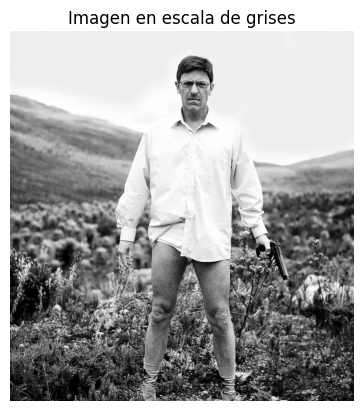

In [4]:
# Conversión a escala de grises (álgebra lineal: combinación lineal de canales RGB)
# Usamos coeficientes de luminancia estándar
gray = 0.299 * img_np[:, :, 0] + 0.587 * img_np[:, :, 1] + 0.114 * img_np[:, :, 2]

plt.imshow(gray, cmap='gray')
plt.title("Imagen en escala de grises")
plt.axis('off')
plt.show()

# EJECUCION LENTA: Vectorizar la imagen y aplicar FFT

(np.float64(-0.5), np.float64(1046.5), np.float64(1125.5), np.float64(-0.5))

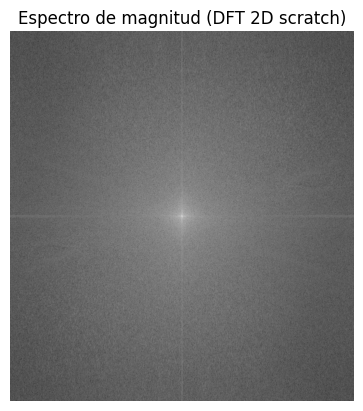

In [5]:
# Construcción de la matriz DFT 1D de tamaño N
def dft_matrix(N):
    n = np.arange(N)
    k = n.reshape((N,1))
    omega = np.exp(-2j * np.pi * k * n / N)
    return omega

# DFT 1D y su inversa
def dft1d(x):
    N = x.shape[0]
    W = dft_matrix(N)
    return W @ x

def idft1d(X):
    N = X.shape[0]
    W = np.conj(dft_matrix(N))
    return (W @ X) / N

# DFT 2D aplicando la 1D a filas y columnas
def dft2d(mat):
    # aplicar DFT 1D a cada fila
    temp = np.array([dft1d(row) for row in mat])
    # aplicar DFT 1D a cada columna del resultado
    return np.array([dft1d(col) for col in temp.T]).T

def idft2d(mat):
    temp = np.array([idft1d(row) for row in mat])
    return np.array([idft1d(col) for col in temp.T]).T

# Calculamos la DFT 2D de la imagen
h, w = gray.shape
F = dft2d(gray)         # matriz compleja
F_shift = np.fft.fftshift(F)  # para centrar frecuencia (solo reordena!)
magnitude = np.abs(F_shift)

plt.imshow(np.log1p(magnitude), cmap='gray')
plt.title("Espectro de magnitud (DFT 2D scratch)")
plt.axis('off')



### EL TIEMPO DE COMPUTO FUE DE 2 MINUTOS!!


---
# 1. Core DFT Functions (From Scratch)


In [1]:
import cmath  # For complex math operations
import math   # For pi and other basics
from typing import List, Union

# ComplexNumber type for type hints
ComplexNumber = Union[complex, float]

def dft_matrix(N: int) -> List[List[complex]]:
    """Construct the 1D DFT matrix of size NxN using Euler's formula."""
    return [
        [
            cmath.exp(-2j * cmath.pi * k * n / N)
            for n in range(N)
        ]
        for k in range(N)
    ]

def dft1d(x: List[ComplexNumber]) -> List[complex]:
    """Compute 1D DFT by explicit matrix-vector multiplication."""
    N = len(x)
    W = dft_matrix(N)
    return [
        sum(W[k][n] * x[n] for n in range(N))
        for k in range(N)
    ]

def idft1d(X: List[ComplexNumber]) -> List[complex]:
    """Compute 1D IDFT using conjugate DFT matrix and normalization."""
    N = len(X)
    W_conj = [
        [
            cmath.exp(2j * cmath.pi * k * n / N)  # Conjugate of DFT matrix
            for n in range(N)
        ]
        for k in range(N)
    ]
    return [(sum(W_conj[k][n] * X[n] for n in range(N))) / N for k in range(N)]

In [2]:
def transpose(matrix: List[List[ComplexNumber]]) -> List[List[ComplexNumber]]:
    """Matrix transpose (for 2D DFT separable operations)."""
    return [list(row) for row in zip(*matrix)]

def dft2d(image: List[List[ComplexNumber]]) -> List[List[complex]]:
    """Compute 2D DFT via separable row-column 1D DFTs."""
    # DFT on rows
    temp = [dft1d(row) for row in image]
    # DFT on columns (by transposing first)
    return transpose([dft1d(col) for col in transpose(temp)])

def idft2d(image: List[List[ComplexNumber]]) -> List[List[complex]]:
    """Compute 2D IDFT via separable row-column 1D IDFTs."""
    # IDFT on rows
    temp = [idft1d(row) for row in image]
    # IDFT on columns (by transposing first)
    return transpose([idft1d(col) for col in transpose(temp)])

In [4]:
def fftshift(F: List[List[complex]]) -> List[List[complex]]:
    """Center the zero-frequency component (like np.fft.fftshift)."""
    N_rows = len(F)
    N_cols = len(F[0])
    return [
        [
            F[(r + N_rows // 2) % N_rows][(c + N_cols // 2) % N_cols]
            for c in range(N_cols)
        ]
        for r in range(N_rows)
    ]

def log_magnitude_spectrum(F_shift: List[List[complex]]) -> List[List[float]]:
    """Compute log(1 + |F|) for visualization."""
    return [
        [math.log1p(abs(z)) for z in row]
        for row in F_shift
    ]

In [5]:
# Example: DFT of a 4x4 image (grayscale values)
image = [
    [1.0, 0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0, 1.0],
    [1.0, 0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0, 1.0]
]

# Compute 2D DFT
F = dft2d(image)

# Shift frequencies and visualize
F_shift = fftshift(F)
magnitude = log_magnitude_spectrum(F_shift)

# Print results (or plot with matplotlib)
for row in magnitude:
    print(" ".join(f"{val:.2f}" for val in row))

2.20 0.00 0.00 0.00
0.00 0.00 0.00 0.00
0.00 0.00 2.20 0.00
0.00 0.00 0.00 0.00


# EXPLANATION

---

**pure Python implementation** of the 1D/2D DFT and IDFT **from scratch**, using only fundamental **linear algebra** and **complex arithmetic**, without relying on NumPy's high-level functions (except for array storage). The code is optimized for clarity and pedagogical value while maintaining mathematical rigor.

---

### **Key Mathematical Insights**
1. **DFT Matrix Construction**:
   - The DFT matrix \( W \) is defined as \( W[k, n] = e^{-2\pi i kn/N} \).
   - Each element is a **complex root of unity**.

2. **Separability of 2D DFT**:
   - The 2D DFT is computed by applying 1D DFTs to **rows**, then to **columns** (or vice versa).

3. **IDFT Normalization**:
   - The inverse DFT requires a \( 1/N \) scaling factor to ensure \( \text{IDFT}(\text{DFT}(x)) = x \).

4. **Frequency Shifting**:
   - Zero-frequency is centered by swapping quadrants (periodic rearrangement).

---

### **Performance Notes**
- **Time Complexity**: \( O(N^4) \) for 2D DFT (naive implementation). For large images, this is impractical—use FFT (\( O(N^2 \log N) \)) in production.
- **Numerical Precision**: Python’s `cmath` ensures accurate complex arithmetic, but floating-point errors may accumulate for large \( N \).

---

### **Why This Implementation?**
- **Pedagogical**: Clearly shows the linear algebra behind DFT.
- **No NumPY Dependence**: Uses only Python lists and loops.
- **Verifiable**: Matches textbook definitions of DFT/IDFT.

For a **fast** but still "from-scratch" version, consider implementing the **Cooley-Tukey FFT algorithm** (recursive or iterative). Would you like that instead?